<a href="https://colab.research.google.com/github/gcfer/reinforcement-learning/blob/main/RL_DQN_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning: Deep Q-Network with Memory and Replay

## Overview

In this notebook, we'll show how to implement a Deep Q-Network (DQN). We'll test it on the cartpole problem in the Open AI gym. 

In [ ]:
import numpy as np
import pandas as pd
import datetime

# Import tensorflow
#!pip install tensorflow-gpu==1.14.0 > /dev/null 2>&1
import tensorflow as tf
print(tf.__version__)

# Check that tf sees the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

# Import libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # this makes plot in high res

2.2.0
/device:GPU:0


Since we are in a remote notebook, we cannot display the progress of the environment in real time. Instead, we store the renderings and show a video at the end of the episode (refer to [this](https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/) guide in case you need it). The only advice that I can give is to import `gym` _after_ the update below.

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Maybe
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 798kB 6.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 49.1.0
    Uninstalling setuptools-49.1.0:
      Successfully uninstalled setuptools-49.1.0


In [ ]:
# Open AI gym
import gym 
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import random
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(2880, 1800))
display.start()

The function below is needed to display the video. I slightly modified it from the original one (that you can in the guide I linked above) to avoid the infinite repetition loop of the video.

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## OpenAI Gym Cartpole

The Cartpole problem is a discrete control problem where we try to keep the pole vertical by moving the cart below it. 

Upon loading the environment, we launch a simulation where the agent chooses at random from the action sample space the next action. Finally, we show the video of the result. What happens is that the problem is considered unsolved (= game over) if the angle between pole and the line orthogonal to the cart axis is larger than a threshold. The parameter `done` specifies when the experiment is over.

In [ ]:
# Load the environment and start
env = wrap_env(gym.make("CartPole-v0"))

In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
    if done: 
      break;
            
env.close()

In [ ]:
show_video()

To better understand the inputs and outputs of the environment, let consider the action space and the observation space.

The action space is of type `Discrete(n)` where `n` is the number of actions. This is equivalent to the discrete set $\{ 0, 1, 2, \dotsc, n-1 \}$.

In [ ]:
env.action_space

Discrete(2)

The observation space is of type `Box(n)`, which means that it is the Cartesian product of `n` intervals.

In [ ]:
env.observation_space

Box(4,)

In [ ]:
[env.observation_space.low, env.observation_space.high]

[array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32)]

When we make a step in the environment, the feedback that we get includes the observation:

In [ ]:
#env = gym.make('CartPole-v0')
# env = Monitor(env, './video', force=True)
env.reset()

obs, r, done, _ = env.step(0)
print(obs)

[ 0.03973992 -0.23932073  0.0346357   0.31406689]


## Deep Q Network

Here we define a class `DQN` that implements the agent's behavior. 

At a high level, the deep Q-network tries to fit the Q-function, which estimates the future reward (discounted at the current epoch) for a given state and action pair:

$$ Q(s, a) := \mathbf{E}[R_t] $$

with $R_t:= r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \cdots$, $r_t$ being the reward at time $t$. Why do we want to estimate $Q$? Suppose to know $Q(s, a)$. Then we can infer the action that maximizes the future discounted return given the state we are in right now:

$$ a^* := \arg\max Q(s, a). $$

This is our policy, i.e. the algorithm that decides what action to take: $\pi^*(s):= a^*$.

The problem is that we don't know $Q$. However, Bellman's equation is what helps us. To be self-contained, let's just observe that the following equation holds by the definition of $Q(s, a)$:

$$ Q(s_t, a_t) = r_t + \gamma Q(s_{t+1}, a_{t+1}). $$

By formally taking the maximum over $a_{t+1}$, we get:

$$ Q(s_t, a_t) = r_t + \gamma Q(s_{t+1}, \pi^*(s_{t+1})). $$

This is true for the optimum policy $\pi^*$, and so we can just try to learn $Q$ by minimizing the loss function

$$ \mathcal{L} = \left[ Q(s_t, a_t) - \left(r_t + \gamma Q(s_{t+1}, \pi^*(s_{t+1}))\right)\right]^2. $$

Other loss functions are possible of course. 

Below we have two implementations. The first one uses two networks, one to fit the term $Q(s_t, a_t)$ and another to fit the term $Q(s_{t+1}, \pi^*(s_{t+1}))$. The second one uses just one network to fit both simultaneously: It is deemed to be unstable, but we'll find it converges, at least in this example. In any case, these are just implementation details.

In [ ]:
# Deep Q Network class
class DQN_2:
  def __init__(self, A, gamma, dim_state_space, n_steps_in_memory, batch_size):
    self.A = A  # set of actions
    self.gamma = gamma  # discount rate
    self.eps_explore = 1  # exploration probability
    self.dim_state_space = dim_state_space
    self.n_actions = len(A)
    self.memory = list()
    self.batch_size = batch_size
    self.model = self._build_model()
    
    # Generate target_model and set weights as model
    self.target_model = self._build_model()
    self.target_model.trainable = False
    self.update_target()

  def _build_model(self, n_hidden_1=None, n_hidden_2=None):
    
    if n_hidden_1 == None:
      n_hidden_1 = 6 * self.dim_state_space
      
    if n_hidden_2 == None:
      n_hidden_2 = 6 * self.dim_state_space

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_hidden_1, 
                                    activation=tf.nn.elu, 
                                    input_dim=self.dim_state_space))  # input
    model.add(tf.keras.layers.Dense(n_hidden_2, 
                                    activation=tf.nn.elu))
    model.add(tf.keras.layers.Dense(self.n_actions,
                                    activation='linear'))  # output
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), loss='mse')
    
    return model
    
  def update_target(self):
    self.target_model.set_weights(self.model.get_weights())

  def remember(self, s, a, r, s_, done):
    self.memory.append([s, a, r, s_, done])

  def forget(self):
    self.memory.pop(0)
    
  def replay_batch(self):
    batch_size = min(self.batch_size, len(self.memory))
    minibatch = random.sample(self.memory, batch_size)
    
    s, a, r, s_, done = zip(*minibatch)
    s = np.concatenate(s)
    s_ = np.concatenate(s_)
    q = self.model.predict(s)
    q_ = self.target_model.predict(s_)
    
    q_target = r + self.gamma * np.max(q_, axis=1) * np.invert(done)
  
    q[range(batch_size), a] = q_target
    
    self.inputs = s
    self.outputs = q

  def replay(self):
    batch_size = min(self.batch_size, len(self.memory))
    minibatch = random.sample(self.memory, batch_size)
              
    inputs = np.zeros((batch_size, self.dim_state_space))
    outputs = np.zeros((batch_size, self.n_actions))

    i = 0
    for s, a, r, s_, done in minibatch:

      if done is True:
          q_ = r
      else:
          q_ = r + self.gamma * np.max(self.target_model.predict(s_)[0])

      q = self.model.predict(s)[0]  # evaluated at current state
      q[a] = q_

      inputs[i] = s
      outputs[i] = q
      i += 1

    self.inputs = inputs
    self.outputs = outputs

  def policy(self, s):
    s = np.reshape(s, [1, self.dim_state_space])
    
    # action selection
    if np.random.uniform() < self.eps_explore:  # explore
      a = np.random.choice(self.A)
    else:  
      q = self.model.predict(s)[0]
      a = np.argmax(q)

    return a

  def learn(self, s, a, r, s_, done):
    self.remember(s, a, r, s_, done)
    self.replay_batch()
    self.model.train_on_batch(self.inputs, self.outputs)
    self.forget()

In [ ]:
# Modified Deep Q Network class with one network only
class DQN_1:
  def __init__(self, A, gamma, dim_state_space, n_steps_in_memory, batch_size):
    self.A = A  # set of actions
    self.gamma = gamma  # discount rate
    self.eps_explore = 1  # initial exploration probability
    self.dim_state_space = dim_state_space
    self.n_actions = len(A)
    # self.memory = n_steps_in_memory * [5 * [None]]
    self.memory = list()
    self.batch_size = batch_size
    self.model = self._build_model()

  def _build_model(self, n_hidden_1=None, n_hidden_2=None):
    
    if n_hidden_1 == None:
      n_hidden_1 = 6 * self.dim_state_space
      
    if n_hidden_2 == None:
      n_hidden_2 = 6 * self.dim_state_space

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_hidden_1, 
                                    activation=tf.nn.elu, 
                                    input_dim=self.dim_state_space))  # input
    model.add(tf.keras.layers.Dense(n_hidden_2, 
                                    activation=tf.nn.elu))
    model.add(tf.keras.layers.Dense(self.n_actions,
                                    activation='linear'))  # output
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025), loss='mse')
    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), loss='mse')
    
    return model

  def remember(self, s, a, r, s_, done):
    self.memory.append([s, a, r, s_, done])

  def forget(self):
    self.memory.pop(0)
    
  def replay_batch(self):
    batch_size = min(self.batch_size, len(self.memory))
    minibatch = random.sample(self.memory, batch_size)
    
    s, a, r, s_, done = zip(*minibatch)
    s = np.concatenate(s)
    s_ = np.concatenate(s_)

    # t_s = tf.convert_to_tensor(s, tf.float32)
    # t_s_ = tf.convert_to_tensor(s_, tf.float32)

    q = self.model.predict(s)
    q_ = self.model.predict(s_)

    q_target = r + self.gamma * np.max(q_, axis=1) * np.invert(done)
  
    q[range(batch_size), a] = q_target
    
    self.inputs = s
    self.outputs = q

  def policy(self, s):
    s = np.reshape(s, [1, self.dim_state_space])
    
    # action selection
    if np.random.uniform() < self.eps_explore:  # explore
      a = np.random.choice(self.A)
    else:  
      q = self.model.predict(s)[0]
      a = np.argmax(q)

    return a
  
  def learn(self, s, a, r, s_, done):
    self.remember(s, a, r, s_, done)
    self.replay_batch()
    self.model.train_on_batch(tf.convert_to_tensor(self.inputs), tf.convert_to_tensor(self.outputs))
    self.forget()

## Training

N.B. The default choice is to use `DQN_2`. To use `DQN_1` instead of `DQN_2`, we need to replace it in the code below, and also comment out the line `agent.update_target()`.

In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Restart environment
# env = Monitor(env, './video', force=True)
MAX_REWARD = 200
env._max_episode_steps = MAX_REWARD

# Parameters
gamma = 0.999               # discount
batch_size = 16             # batch size needs to be small (remember "minibatch")
n_batch_in_memory = 32
n_steps_in_memory = n_batch_in_memory * batch_size  # number of steps to remember
n_episodes = 200
eps_explore_min = 0.0001
eps_half_life = 30 # episodes
streak_target = 7  # after this number of contiguous successes, training stops
hist_reward = np.zeros(n_episodes)

A = np.arange(env.action_space.n)
dim_state_space = env.observation_space.shape[0]

# Start training
agent = DQN_1(A, gamma, dim_state_space, n_steps_in_memory, batch_size)

template = "\rEpisode: {:3d}/{:3d} | Steps: {:3.2f}k | Reward: {:3.0f} | Explore: {:.4f} | Num batches: {:3d} | Memory: {:4d} | Duration: {:.2f} s"

# init
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

for _ in range(n_steps_in_memory):
  a = agent.policy(s)
  s_, r, done, _ = env.step(a)
  s_ = np.reshape(s_, [1, dim_state_space])
  agent.remember(s, a, r, s_, done)

cum_steps = n_steps_in_memory

In [ ]:
# start episodes
for e in range(n_episodes):
  start_time = datetime.datetime.now()
  
  agent.eps_explore = max(0.5 ** (e/eps_half_life), eps_explore_min)

  s = env.reset()
  s = np.reshape(s, [1, dim_state_space])
  # s = tf.convert_to_tensor(s, dtype=tf.float32)
  
  done = False
  cum_reward = 0
  
  while not done:
    
    a = agent.policy(s)
    s_, r, done, _ = env.step(a)
    s_ = np.reshape(s_, [1, dim_state_space])

    agent.learn(s, a, r, s_, done)
    cum_reward += r
    
    s = s_
    cum_steps += 1
  
  dt = datetime.datetime.now() - start_time
  print(template.format(e+1, n_episodes, float(cum_steps/1000), cum_reward, agent.eps_explore, n_batch_in_memory, len(agent.memory), dt.total_seconds()), end='')
  
  hist_reward[e] = cum_reward
  # agent.update_target()
  
  if e > streak_target and np.mean(hist_reward[e-streak_target:e]) > MAX_REWARD-1:
    break
            
env.close()

Episode: 104/200 | Steps: 4.91k | Reward: 200 | Explore: 0.0926 | Num batches:  32 | Memory:  512 | Duration: 17.33 s

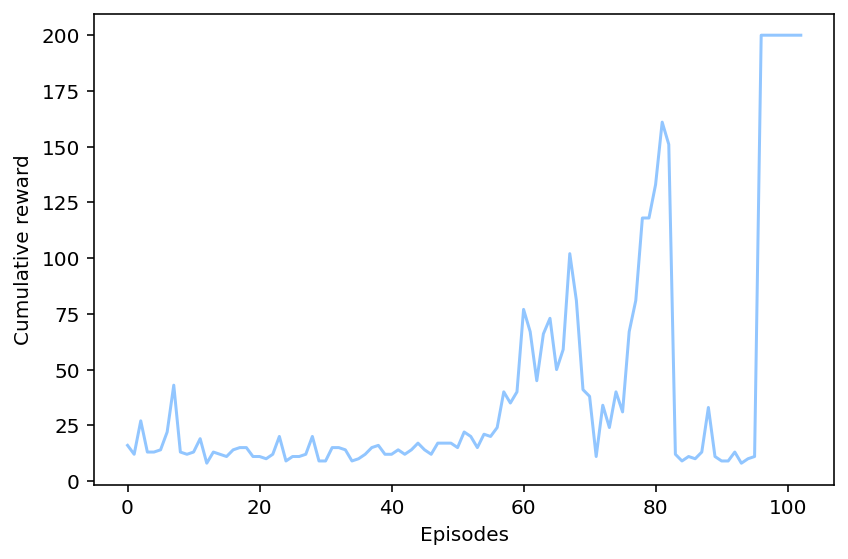

In [ ]:
plt.plot(hist_reward[0:e], label='Reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.tight_layout()
plt.show()

Empirical observations:

*   Increasing the memory while keeping fixed the batch size slows down learning. This is probably because of the random sampling from the memory. To work well, many examples in the memory should be good, but at the beginning memory is just full of garbage (trial-and-error samples). Therefore, for a long time we try to learn from garbage. An alternative way is not to use random sampling and skew the sampling towards more recent samples. Another alternative is to let the memory grow as the number of episodes grow. Optimal for cartpole seems to be the pair: 32 batches of length 16.
*   Increasing the step size is dangerous, even with Adam optimizer (e.g. cartpole does not converge with step = 0.025 but it does converge with step = 0.005).
*   Decreasing the discount can speed up learning. 
*   Decreasing the exploration probability half life too much can be dangerous. There is a tradeoff between how much of the space we need to explore and how fast the algorithm can learn. For example, decreasing the half life below 35 episodes will make the algorithm noisy and unstable (especially if the half life goes down to 20 or below) while increasing it will make the algorithm slow.



## Trying it

In [ ]:
env = wrap_env(gym.make("CartPole-v0"))
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

done = False
cum_reward = 0

agent.eps_explore = 0

while not done:

  env.render()
  a = agent.policy(s)
  s_, r, done, _ = env.step(a)
  s_ = np.reshape(s_, [1, dim_state_space])

  cum_reward += r

  s = s_

env.close()

print('We got a reward equal to {:.0f}'.format(cum_reward))

We got a reward equal to 200


In [ ]:
show_video()